# Example 2 - Regularized versus Non-Regularized Optimal Transport

This notebook contains a comparison of the Optimal Transport Plans obtained by changing the
entropic regulirizer parameter $\epsilon$. In the case that $\epsilon = 0$, we instead use
the Earth-Movers Distance, which gives the solution for the Optimal Transport problem without regularization.

In [80]:
# using Pkg
# Pkg.activate("../.")
using OptimalTransport, VegaLite, LinearAlgebra, DataFrames, Distances, LaTeXStrings
ot = OptimalTransport

 Activating environment at `~/MEGAsync/EMAp/OptimalTransport.jl/Project.toml`


OptimalTransport

### 1. Generating the Marginal Distributions
Below we create two random discrete probability distributions. Note that $\mu,\nu$ represent the 2D location of the mass, while
$\mu_n, \nu_m$ represent the amount of mass in each point. Then, the cost matrix $C$ is built using the Euclidean distance.

In [28]:
n,m = 10,10

μ = rand(max(n,m),2)
ν = rand(max(n,m),2).+0.5;
μ_n = rand(n)
ν_m = rand(m)
μ_n = μ_n/sum(μ_n)
ν_m = ν_m/sum(ν_m);
n,m = max(n,m),max(n,m);
C = Distances.pairwise(Distances.SqEuclidean(), μ', ν');

### 2. Obtaining the Optimal Plans
The Optimal Transport Plans as obtained for the varying values of $\epsilon$.

In [102]:
ϵs = [0, 0.01,0.1,1,10]
γs = []
for ϵ in ϵs
    if ϵ == 0 
        γ = round.(ot.emd(μ_n,ν_m,C),digits=4)
        push!(γs,γ)
    else
        γ = round.(ot.sinkhorn(μ_n, ν_m, C, ϵ),digits=4)
        push!(γs,γ)
    end
end

### 3. Plotting Functions

This cells contain auxiliary functions for visualizing the transportation plans.

In [164]:
"""
    CreateEdges(μ,ν,γ)
Creates the edges for plotting.
μ and ν correspond to the positions of the mass
of the distributions.
"""
function CreateEdges(μ,ν,γ)
    edges = Array{Float64}(undef, 0, 2)
    pe    = []
    for i in 1:size(μ)[1], j in 1:size(ν)[1]
        edges  = vcat(edges,[μ[i,1],μ[i,2]]')
        edges  = vcat(edges,[ν[j,1],ν[j,2]]')
        pe     = vcat(pe,string([i,j]))
        pe     = vcat(pe,string([i,j]))
    end
    df = DataFrame(edges_x=edges[:,1],edges_y = edges[:,2],pe=pe);
    edge_w = []
    for i in 1:size(γ)[1], j in 1:size(γ)[1]
        edge_w = vcat(edge_w,γ[i,j])
        edge_w = vcat(edge_w,γ[i,j])
    end
    df["ew"] = edge_w./maximum(edge_w);
    return df
end

CreateEdges

In [165]:
"""
    PlotOT(μ,ν,γ;title="",width=200,height=200)
VegaLite.jl specification for creating visulizations
of Optimal Transport plan.
"""
function PlotOT(μ,ν,γ;title="",width=200,height=200)
    df = CreateEdges(μ,ν,γ)
    v1 = @vlplot(
        mark={:circle,opacity=1},
        x={μ[:,1],type="quantitative",axis=nothing},
        y={μ[:,2],type="quantitative",axis=nothing},
        width=width,
        height=height,
        size={μ_n,legend=nothing,type="q"})
    v2 = @vlplot(
        mark={"type"=:circle,color="red",opacity=1},
        x={ν[:,1],type="quantitative",axis=nothing},
        y={ν[:,2],type="quantitative",axis=nothing},
        width=width,
        height=height,
        size={ν_m,legend=nothing,type="q"})

    v3 = @vlplot(
        mark={"type"=:line,color="black",clip=false},
        data = df,
        encoding={
        x={"edges_x:q",axis=nothing},
        y={"edges_y:q",axis=nothing},
        opacity={"ew:q",legend=nothing},
        size={"ew:o",scale={range=[0,2]},legend=nothing},
        detail={"pe:o"}},
        width=width,
        height=height
    )
    v = @vlplot(view={stroke=nothing},title=title)+v3+v2+v1
    return v
end;

### 4. Visual Comparison of Transport Plans for Varying $\epsilon$

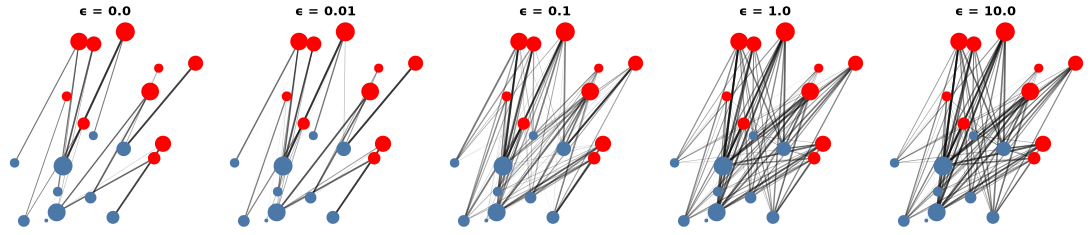

In [163]:
local v
for (ϵ,γ) in zip(ϵs,γs)
   if ϵ == 0
        v = PlotOT(μ,ν,γ,title=string("ϵ = ",ϵ))
    else
        v = hcat(v,PlotOT(μ,ν,γ,title=string("ϵ = ",ϵ)))
    end
end
v